Updated with code by Dr Jittisak, changed visualization to DC with up to date thresholds.

Changed the download to use text-only progress indicators.

Changed the processing cell so that it gets the file list from the current directory (so that it can be run independently from the first cell).

In [48]:
#01_download_files.py
#Download the 2 most recent 00UTC_d03.nc files
#import requests
#from bs4 import BeautifulSoup
#from tqdm.notebook import tqdm # Import tqdm
#import os # Import os module
#import sys # Import sys module for text-based progress

#url = "https://tiservice.hii.or.th/wrf-roms/netcdf"
#response = requests.get(url)
#soup = BeautifulSoup(response.content, 'html.parser')

# Find all links on the page
#links = [a['href'] for a in soup.find_all('a', href=True)]

# Filter for files ending with 'd03.nc' and sort them
#target_files = sorted([link for link in links if link.endswith('00UTC_d03.nc')], reverse=False)

# Select the bottommost two files
#bottommost_files = []
#if len(target_files) >= 2:
#    bottommost_files = target_files[-2:] # Select the last two files
#    print(f"The bottommost two files ending with '00UTC_d03.nc' are: {bottommost_files}")
#elif len(target_files) == 1:
#    bottommost_files = target_files[-1:] # Select the last file
#    print(f"Only one file ending with '00UTC_d03.nc' found: {bottommost_files}")
#else:
#    print("No files ending with '00UTC_d03.nc' found.")


# Download the files
#for bottommost_file in bottommost_files:
#    file_url = f"{url}/{bottommost_file}"
#    # Check if the file already exists
#    if os.path.exists(bottommost_file):
 #       print(f"{bottommost_file} already exists. Skipping download.")
 #       continue # Skip to the next file
  #  print(f"Downloading {file_url}...")
  #  with requests.get(file_url, stream=True) as r:
  #      r.raise_for_status()
  #      total_size = int(r.headers.get('content-length', 0)) # Get the total size
  #      downloaded_size = 0
  #      with open(bottommost_file, 'wb') as f:
  #          #with tqdm(total=total_size, unit='B', unit_scale=True, desc=bottommost_file) as pbar: # Add tqdm progress bar
  #              for chunk in r.iter_content(chunk_size=8192):
   #                 f.write(chunk)
   #                 downloaded_size += len(chunk)
    #                #pbar.update(len(chunk)) # Update the progress bar
    #                progress = (downloaded_size / total_size) * 100
    #                sys.stdout.write(f"\rDownloading {bottommost_file}: {progress:.2f}%")
    #                sys.stdout.flush()
    #    sys.stdout.write('\n') # Newline after download is complete
    #    sys.stdout.flush()
  #  print(f"Downloaded {bottommost_file}")#

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#!cp 2025-09-11_00UTC_d03.nc /content/drive/MyDrive


Mounted at /content/drive


In [49]:


#from google.colab import drive
#drive.mount('/content/drive')
#import xarray as xr
#ds = xr.open_dataset("/content/drive/MyDrive/2025-09-11_00UTC_d03.nc")
#print(ds)

In [3]:
# --- Setup & imports ---
from pathlib import Path
import os, sys, requests
from bs4 import BeautifulSoup
from google.colab import drive

drive.mount('/content/drive')

SAVE_DIR = Path('/content/drive/MyDrive/wrf_roms_nc')
SAVE_DIR.mkdir(parents=True, exist_ok=True)

URL = "https://tiservice.hii.or.th/wrf-roms/netcdf"
PATTERN = "*00UTC_d03.nc"
NUM_FILES = 2  # how many most-recent you want

def list_local_files(k=2):
    files = sorted(SAVE_DIR.glob(PATTERN))
    return files[-k:] if len(files) >= k else files

def fetch_latest_to_drive(k=2):
    # scrape directory index
    soup = BeautifulSoup(requests.get(URL).content, 'html.parser')
    names = sorted([a['href'] for a in soup.find_all('a', href=True)
                    if a['href'].endswith('00UTC_d03.nc')])
    desired = names[-k:] if len(names) >= k else names

    outpaths = []
    for name in desired:
        dest = SAVE_DIR / name
        if dest.exists():
            print(f"{dest.name} already exists in Drive — skipping download.")
            outpaths.append(dest)
            continue

        print(f"Downloading {name} -> {dest}")
        with requests.get(f"{URL}/{name}", stream=True) as r:
            r.raise_for_status()
            total = int(r.headers.get('content-length', 0))
            done = 0
            with open(dest, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    if not chunk:
                        continue
                    f.write(chunk)
                    if total:
                        done += len(chunk)
                        sys.stdout.write(f"\r{name}: {done*100/total:.1f}%")
                        sys.stdout.flush()
            sys.stdout.write("\n")
        outpaths.append(dest)
    return outpaths

# --- Main flow: prefer local, else download ---
paths = list_local_files(NUM_FILES)
if not paths:
    print("No matching files found in Drive. Fetching from server...")
    paths = fetch_latest_to_drive(NUM_FILES)

print("Ready files:")
for p in paths:
    print(" -", p.as_posix())

# Example: open the newest one with xarray
# import xarray as xr
# ds = xr.open_dataset(paths[-1].as_posix())
# ds


Mounted at /content/drive
Ready files:
 - /content/drive/MyDrive/wrf_roms_nc/2025-09-11_00UTC_d03.nc
 - /content/drive/MyDrive/wrf_roms_nc/2025-09-12_00UTC_d03.nc


In [1]:
!pip install netCDF4
!pip install numpy
!pip install matplotlib
#!pip install time
#!pip install threading
!mkdir index_yesterday
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 27.0 MB/s eta 0:00:00


In [4]:
# @title From the library
# CODE https://github.com/cffdrs/cffdrs_py/blob/main/cffdrs/fwi.py

from math import exp, log, sqrt

# used in conversion between FFMC and moisture content
FFMC_COEFFICIENT = 250.0 * 59.5 / 101.0


def ffmc(ffmc_yda, temp, rh, ws, prec):
    """
    Fine Fuel Moisture Code Calculation

    Parameters
    ----------
    ffmc_yda : float
        The Fine Fuel Moisture Code from previous iteration
   temp : float
      Temperature (centigrade)
    rh : float
      Relative Humidity (%)
    prec : float
       Precipitation (mm)
    ws : float
       Wind speed (km/h)

    Returns
    -------
    float
        Fine Fuel Moisture Code

    Notes
    -----
    All code is based on a C code library that was written by Canadian
    Forest Service Employees, which was originally based on
    the Fortran code listed in the reference below. All equations
    in this code refer to that document.

    Equations and FORTRAN program for the Canadian Forest Fire
    Weather Index System. 1985. Van Wagner, C.E.; Pickett, T.L.
    Canadian Forestry Service, Petawawa National Forestry
    Institute, Chalk River, Ontario. Forestry Technical Report 33.
    18 p.

    Additional reference on FWI system

    Development and structure of the Canadian Forest Fire Weather
    Index System. 1987. Van Wagner, C.E. Canadian Forestry Service,
    Headquarters, Ottawa. Forestry Technical Report 35. 35 p.
    """
    if ffmc_yda < 0 or ffmc_yda > 101:
        raise ValueError(f'Invalid ffmc_yda: {ffmc_yda}')
    if rh < 0 or rh > 100:
        raise ValueError(f'Invalid rh: {rh}')
    if prec < 0:
        raise ValueError(f'Invalid prec: {prec}')
    if ws < 0:
        raise ValueError(f'Invalid ws: {ws}')
    # Eq. 1
    wmo = FFMC_COEFFICIENT * (101 - ffmc_yda) / (59.5 + ffmc_yda)
    # Eq. 2 Rain reduction to allow for loss in
    #  overhead canopy
    ra = (prec - 0.5) if (prec > 0.5) else prec
    # Eqs. 3a and 3b
    wmo = ((wmo + 0.0015 * (wmo - 150) * (wmo - 150) *
            sqrt(ra) + 42.5 * ra * exp(-100 / (251 - wmo))
            * (1 - exp(-6.93 / ra))) if (wmo > 150) else
           (wmo + 42.5 * ra * exp(-100 / (251 - wmo)) *
            (1 - exp(-6.93 / ra)))) if (prec > 0.5) else wmo
    # The real moisture content of pine litter ranges up to about 250 percent,
    # so we cap it at 250
    wmo = 250 if (wmo > 250) else wmo
    # Eq. 4 Equilibrium moisture content from drying
    ed = (0.942 * (rh ** 0.679) + (11 * exp((rh - 100) / 10)) + 0.18 *
          (21.1 - temp) * (1 - 1 / exp(rh * 0.115)))
    # Eq. 5 Equilibrium moisture content from wetting
    ew = (0.618 * (rh ** 0.753) + (10 * exp((rh - 100) / 10)) + 0.18 *
          (21.1 - temp) * (1 - 1 / exp(rh * 0.115)))
    # Eq. 6a (ko) Log drying rate at the normal
    #  termperature of 21.1 C
    z = (0.424 * (1 - (((100 - rh) / 100) ** 1.7)) + 0.0694 *
         sqrt(ws) * (1 - ((100 - rh) / 100) ** 8)) if (wmo < ed and wmo < ew) else 0
    # Eq. 6b Affect of temperature on  drying rate
    x = z * 0.581 * exp(0.0365 * temp)
    # Eq. 8
    wm = (ew - (ew - wmo) / (10 ** x)) if (wmo < ed and wmo < ew) else wmo
    # Eq. 7a (ko) Log wetting rate at the normal
    #  termperature of 21.1 C
    z = (0.424 * (1 - (rh / 100) ** 1.7) + 0.0694 * sqrt(ws) *
         (1 - (rh / 100) ** 8)) if (wmo > ed) else z
    # Eq. 7b Affect of temperature on  wetting rate
    x = z * 0.581 * exp(0.0365 * temp)
    # Eq. 9
    wm = (ed + (wmo - ed) / (10 ** x)) if (wmo > ed) else wm
    # Eq. 10 Final ffmc calculation
    ffmc1 = (59.5 * (250 - wm)) / (FFMC_COEFFICIENT + wm)
    # Constraints
    ffmc1 = 101 if (ffmc1 > 101) else ffmc1
    ffmc1 = 0 if (ffmc1 < 0) else ffmc1
    return ffmc1


def dmc(dmc_yda, temp, rh, prec, lat, mon, lat_adjust=True):
    """
    Duff Moisture Code Calculation

    Parameters
    ----------
    dmc_yda : float
       The Duff Moisture Code from previous iteration
    temp : float
       Temperature (centigrade)
    rh : flat
       Relative Humidity (%)
    prec : float
       Precipitation(mm)
    lat : float
       Latitude (decimal degrees)
    mon : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
       Month
    lat_adjust : bool, default=True
       Latitude adjustment

    Returns
    -------
    float
        Duff Moisture Code

    Notes
    -----
    All code is based on a C code library that was written by Canadian
    Forest Service Employees, which was originally based on
    the Fortran code listed in the reference below. All equations
    in this code refer to that document.

    Equations and FORTRAN program for the Canadian Forest Fire
    Weather Index System. 1985. Van Wagner, C.E.; Pickett, T.L.
    Canadian Forestry Service, Petawawa National Forestry
    Institute, Chalk River, Ontario. Forestry Technical Report 33.
    18 p.

    Additional reference on FWI system

    Development and structure of the Canadian Forest Fire Weather
    Index System. 1987. Van Wagner, C.E. Canadian Forestry Service,
    Headquarters, Ottawa. Forestry Technical Report 35. 35 p.
    """
    if dmc_yda < 0:
        raise ValueError(f'Invalid dc_yda: {dmc_yda}')
    if rh < 0 or rh > 100:
        raise ValueError(f'Invalid rh: {rh}')
    if prec < 0:
        raise ValueError(f'Invalid prec: {prec}')
    if mon < 1 or mon > 12 or not isinstance(mon, int):
        raise ValueError(f'Invalid mon: {mon}')
    # Reference latitude for DMC day length adjustment
    # 46N: Canadian standard, latitude >= 30N   (Van Wagner 1987)
    ell01 = [6.5, 7.5, 9, 12.8, 13.9, 13.9, 12.4, 10.9, 9.4, 8, 7, 6]
    # 20N: For 30 > latitude >= 10
    ell02 = [7.9, 8.4, 8.9, 9.5, 9.9, 10.2, 10.1, 9.7, 9.1, 8.6, 8.1, 7.8]
    # 20S: For -10 > latitude >= -30
    ell03 = [10.1, 9.6, 9.1, 8.5, 8.1, 7.8, 7.9, 8.3, 8.9, 9.4, 9.9, 10.2]
    # 40S: For -30 > latitude
    ell04 = [11.5, 10.5, 9.2, 7.9, 6.8, 6.2, 6.5, 7.4, 8.7, 10, 11.2, 11.8]
    # For latitude near the equator, we simple use a factor of 9 for all months
    # constrain low end of temperature
    temp = -1.1 if (temp < 1.1) else temp
    # Eq. 16 - The log drying rate
    rk = 1.894 * (temp + 1.1) * (100 - rh) * ell01[mon - 1] * 1e-04
    # Adjust the day length  and thus the drying r, based on latitude and month
    if lat_adjust:
        rk = (1.894 * (temp + 1.1) * (100 - rh) * ell02[mon - 1] * 1e-04) if (30 >= lat > 10) else rk
        rk = (1.894 * (temp + 1.1) * (100 - rh) * ell03[mon - 1] * 1e-04) if (-10 >= lat > -30) else rk
        rk = (1.894 * (temp + 1.1) * (100 - rh) * ell04[mon - 1] * 1e-04) if (-30 >= lat >= -90) else rk
        rk = (1.894 * (temp + 1.1) * (100 - rh) * 9 * 1e-04) if (10 >= lat > -10) else rk
    # Constrain P
    if prec <= 1.5:
        pr = dmc_yda
    else:
        ra = prec
        # Eq. 11 - Net rain amount
        rw = 0.92 * ra - 1.27
        # Alteration to Eq. 12 to calculate more accurately
        wmi = 20 + 280 / exp(0.023 * dmc_yda)
        # Eqs. 13a, 13b, 13c
        b = (100 / (0.5 + 0.3 * dmc_yda)) if (dmc_yda <= 33) else (
            (14 - 1.3 * log(dmc_yda)) if (dmc_yda <= 65) else
            (6.2 * log(dmc_yda) - 17.2))
        # Eq. 14 - Moisture content after rain
        wmr = wmi + 1000 * rw / (48.77 + b * rw)
        # Alteration to Eq. 15 to calculate more accurately
        pr = 43.43 * (5.6348 - log(wmr - 20))
    pr = 0 if (pr < 0) else pr
    # Calculate final P (DMC)
    dmc1 = pr + rk
    dmc1 = 0 if (dmc1 < 0) else dmc1
    return dmc1


def dc(dc_yda, temp, rh, prec, lat, mon, lat_adjust=True):
    """
    Drought Code Calculation

    Parameters
    ----------
    dc_yda : float
       The Drought Code from previous iteration
    temp : float
       Temperature (centigrade)
    rh : float
       Relative Humidity (%)
    prec : float
       Precipitation(mm)
    lat : float
       Latitude (decimal degrees)
    mon : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
       Month
    lat_adjust : bool, default=True
       Latitude adjustment

    Returns
    -------
    float
        Drought Code

    Notes
    -----
    All code is based on a C code library that was written by Canadian
    Forest Service Employees, which was originally based on
    the Fortran code listed in the reference below. All equations
    in this code refer to that document.

    Equations and FORTRAN program for the Canadian Forest Fire
    Weather Index System. 1985. Van Wagner, C.E.; Pickett, T.L.
    Canadian Forestry Service, Petawawa National Forestry
    Institute, Chalk River, Ontario. Forestry Technical Report 33.
    18 p.

    Additional reference on FWI system

    Development and structure of the Canadian Forest Fire Weather
    Index System. 1987. Van Wagner, C.E. Canadian Forestry Service,
    Headquarters, Ottawa. Forestry Technical Report 35. 35 p.
    """
    if dc_yda < 0:
        raise ValueError(f'Invalid dc_yda: {dc_yda}')
    if rh < 0 or rh > 100:
        raise ValueError(f'Invalid rh: {rh}')
    if prec < 0:
        raise ValueError(f'Invalid prec: {prec}')
    if mon < 1 or mon > 12 or not isinstance(mon, int):
        raise ValueError(f'Invalid mon: {mon}')
    # Day length factor for DC Calculations
    # 20N: North of 20 degrees N
    fl01 = [-1.6, -1.6, -1.6, 0.9, 3.8, 5.8, 6.4, 5, 2.4, 0.4, -1.6, -1.6]
    # 20S: South of 20 degrees S
    fl02 = [6.4, 5, 2.4, 0.4, -1.6, -1.6, -1.6, -1.6, -1.6, 0.9, 3.8, 5.8]
    # Near the equator, we just use 1.4 for all months.
    # Constrain temperature
    temp = -2.8 if (temp < 2.8) else temp
    # Eq. 22 - Potential Evapotranspiration
    pe = (0.36 * (temp + 2.8) + fl01[mon - 1]) / 2
    # Daylength factor adjustment by latitude for Potential Evapotranspiration
    if lat_adjust:
        pe = ((0.36 * (temp + 2.8) + fl02[mon - 1]) / 2) if (lat <= -20) else pe
        pe = ((0.36 * (temp + 2.8) + 1.4) / 2) if (-20 < lat <= 20) else pe
    # Cap potential evapotranspiration at 0 for negative winter DC values
    pe = 0 if (pe < 0) else pe
    ra = prec
    # Eq. 18 - Effective Rainfall
    rw = 0.83 * ra - 1.27
    # Eq. 19
    smi = 800 * exp(-1 * dc_yda / 400)
    # Alteration to Eq. 21
    dr0 = dc_yda - 400 * log(1 + 3.937 * rw / smi)
    dr0 = 0 if (dr0 < 0) else dr0
    # if precip is less than 2.8 then use yesterday's DC
    dr = dc_yda if (prec <= 2.8) else dr0
    # Alteration to Eq. 23
    dc1 = dr + pe
    dc1 = 0 if (dc1 < 0) else dc1
    return dc1


def isi(ffmc, ws, fbp_mod=False):
    """
    Initial Spread Index Calculation

    Parameters
    ----------
    ffmc : float
       Fine Fuel Moisture Code
    ws : float
       Wind Speed (km/h)
    fbp_mod : bool, default=False
       Use the fbp modification at the extreme end

    Returns
    -------
    float
        Intial Spread Index

    Notes
    -----
    Equations are from Van Wagner (1985) as listed below, except for the modification for fbp
    taken from FCFDG (1992).

    Equations and FORTRAN program for the Canadian Forest Fire
    Weather Index System. 1985. Van Wagner, C.E.; Pickett, T.L.
    Canadian Forestry Service, Petawawa National Forestry
    Institute, Chalk River, Ontario. Forestry Technical Report 33.
    18 p.

    Forestry Canada  Fire Danger Group (FCFDG) (1992). Development and
    Structure of the Canadian Forest Fire Behavior Prediction System."
    Technical ReportST-X-3, Forestry Canada, Ottawa, Ontario.
    """
    if ffmc < 0 or ffmc > 101:
        raise ValueError(f'Invalid ffmc: {ffmc}')
    if ws < 0:
        raise ValueError(f'Invalid ws: {ws}')
    # Eq. 10 - Moisture content
    fm = FFMC_COEFFICIENT * (101 - ffmc) / (59.5 + ffmc)
    # Eq. 24 - Wind Effect
    # the ifelse, also takes care of the ISI modification for the fbp functions
    # This modification is Equation 53a in FCFDG (1992)
    fW = (12 * (1 - exp(-0.0818 * (ws - 28)))) if (ws >= 40 and fbp_mod) else exp(0.05039 * ws)
    # Eq. 25 - Fine Fuel Moisture
    fF = 91.9 * exp(-0.1386 * fm) * (1 + (fm ** 5.31) / 49300000)
    # Eq. 26 - Spread Index Equation
    isi = 0.208 * fW * fF
    return isi


def bui(dmc, dc):
    """
    Buildup Index Calculation

    Parameters
    ----------
    dc : float
       Drought Code
    dmc : float
       Duff Moisture Code

    Returns
    -------
    float
        Buildup Index

    Notes
    -----
    All code is based on a C code library that was written by Canadian
    Forest Service Employees, which was originally based on
    the Fortran code listed in the reference below. All equations
    in this code refer to that document.

    Equations and FORTRAN program for the Canadian Forest Fire
    Weather Index System. 1985. Van Wagner, C.E.; Pickett, T.L.
    Canadian Forestry Service, Petawawa National Forestry
    Institute, Chalk River, Ontario. Forestry Technical Report 33.
    18 p.

    Additional reference on FWI system

    Development and structure of the Canadian Forest Fire Weather
    Index System. 1987. Van Wagner, C.E. Canadian Forestry Service,
    Headquarters, Ottawa. Forestry Technical Report 35. 35 p.
    """
    if dmc < 0:
        raise ValueError(f'Invalid dmc: {dmc}')
    if dc < 0:
        raise ValueError(f'Invalid dc: {dc}')
    # Eq. 27a
    bui1 = 0 if (dmc == 0 and dc == 0) else (0.8 * dc * dmc / (dmc + 0.4 * dc))
    # Eq. 27b - next 3 lines
    p = 0 if (dmc == 0) else ((dmc - bui1) / dmc)
    cc = 0.92 + ((0.0114 * dmc) ** 1.7)
    bui0 = dmc - cc * p
    # Constraints
    bui0 = 0 if (bui0 < 0) else bui0
    bui1 = bui0 if (bui1 < dmc) else bui1
    return bui1


def fwi(isi, bui):
    """
    Fire Weather Index Calculation

    Parameters
    ----------
    isi : float
        Initial Spread Index
    bui : float
        Buildup Index

    Returns
    -------
    float
        Fire Weather Index

    Notes
    -----
    All code is based on a C code library that was written by Canadian
    Forest Service Employees, which was originally based on
    the Fortran code listed in the reference below. All equations
    in this code refer to that document.

    Equations and FORTRAN program for the Canadian Forest Fire
    Weather Index System. 1985. Van Wagner, C.E.; Pickett, T.L.
    Canadian Forestry Service, Petawawa National Forestry
    Institute, Chalk River, Ontario. Forestry Technical Report 33.
    18 p.

    Additional reference on FWI system

    Development and structure of the Canadian Forest Fire Weather
    Index System. 1987. Van Wagner, C.E. Canadian Forestry Service,
    Headquarters, Ottawa. Forestry Technical Report 35. 35 p.
    """
    if isi < 0:
        raise ValueError(f'Invalid isi: {isi}')
    if bui < 0:
        raise ValueError(f'Invalid bui: {bui}')
    # Eqs. 28b, 28a, 29
    bb = (0.1 * isi * (1000 / (25 + 108.64 / exp(0.023 * bui)))) if (
            bui > 80) else (0.1 * isi * (0.626 * (bui ** 0.809) + 2))
    # Eqs. 30b, 30a
    fwi = bb if (bb <= 1.0) else exp(2.72 * ((0.434 * log(bb)) ** 0.647))
    return fwi

In [6]:
# ===== Robust loader for wrf_roms_nc daily NetCDFs =====
from pathlib import Path
import os
import math
import traceback

# --- (1) Mount Google Drive if running in Colab ---
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive', force_remount=False)
except Exception:
    pass  # not in Colab; ignore

# --- (2) Config: folder that holds the *_00UTC_d03.nc files ---
DATA_DIR = Path('/content/drive/MyDrive/wrf_roms_nc')

# --- (3) Helper: human-friendly size ---
def _fmt_bytes(n):
    if n is None:
        return "?"
    units = ["B","KB","MB","GB","TB"]
    i = 0
    while n >= 1024 and i < len(units)-1:
        n /= 1024.0; i += 1
    return f"{n:.1f} {units[i]}"

# --- (4) Find candidates and sort by mtime (oldest -> newest) ---
if not DATA_DIR.exists():
    raise FileNotFoundError(f"Data folder not found: {DATA_DIR}. "
                            "Make sure Drive is mounted and the path is correct.")

all_files = sorted(
    [p for p in DATA_DIR.glob('*_00UTC_d03.nc') if p.is_file()],
    key=lambda p: p.stat().st_mtime
)

if not all_files:
    # Show what *does* exist to help debugging
    examples = list(DATA_DIR.glob('*.nc'))[:10]
    hint = "\n".join(f" - {e.name}" for e in examples) if examples else " (no .nc files)"
    raise FileNotFoundError(
        f"No files matching '*_00UTC_d03.nc' found in {DATA_DIR}.\n"
        f"Here are some .nc files I can see:\n{hint}"
    )

# --- (5) Pick yesterday/today robustly ---
if len(all_files) >= 2:
    y_path = all_files[-2]
    t_path = all_files[-1]
else:
    # only one file available: use the same for both to avoid index errors
    y_path = t_path = all_files[-1]

print("Using files:")
print(f"  yesterday: {y_path.name}  ({_fmt_bytes(y_path.stat().st_size)})")
print(f"  today    : {t_path.name}  ({_fmt_bytes(t_path.stat().st_size)})")

# Optional: if you still want the date strings derived from the names
yesterday_str = y_path.name.split('_')[0]   # e.g., "2025-09-11"
today_str     = t_path.name.split('_')[0]   # e.g., "2025-09-12"


# --- (6) Your processing hook ------------------------------------
# If you already have read_nc(yesterday_file, today_file), keep that and remove the stub.
def read_nc(yesterday_nc_file: str, today_nc_file: str):
    """
    Minimal stub so this script runs end-to-end.
    Replace with your real logic (precip aggregation, etc.).
    """
    try:
        import netCDF4 as nc
        yds = nc.Dataset(yesterday_nc_file, mode="r")
        tds = nc.Dataset(today_nc_file,     mode="r")
        try:
            def _quick(ds, tag):
                # print a few basics; adapt to variables you actually need
                dims = {k: int(v.size) for k, v in ds.dimensions.items()}
                vars_list = list(ds.variables.keys())[:12]
                print(f"[{tag}] dims={dims}")
                print(f"[{tag}] first variables: {vars_list}")
            _quick(yds, "yesterday")
            _quick(tds, "today")
        finally:
            yds.close()
            tds.close()
        print("read_nc(): completed basic open/inspect successfully.")
    except Exception as e:
        print("read_nc() failed:")
        traceback.print_exc()
        raise

# --- (7) Always pass FULL PATHS to avoid cwd-related FileNotFoundError ---
read_nc(str(y_path), str(t_path))

# If you absolutely need the older "constructed name" style, do this (but full path!):
# read_nc(str(DATA_DIR / f'{yesterday_str}_00UTC_d03.nc'),
#         str(DATA_DIR / f'{today_str}_00UTC_d03.nc'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using files:
  yesterday: 2025-09-11_00UTC_d03.nc  (744.2 MB)
  today    : 2025-09-12_00UTC_d03.nc  (744.2 MB)
[yesterday] dims={'time': 73, 'ncl1': 8, 'south_north': 699, 'west_east': 543}
[yesterday] first variables: ['time', 'DateTime', 'year', 'month', 'day', 'hour', 'minute', 'Mercator', 'lat', 'lon', 'Z_sfc', 'SST']
[today] dims={'time': 73, 'ncl1': 8, 'south_north': 699, 'west_east': 543}
[today] first variables: ['time', 'DateTime', 'year', 'month', 'day', 'hour', 'minute', 'Mercator', 'lat', 'lon', 'Z_sfc', 'SST']
read_nc(): completed basic open/inspect successfully.


Using files: 2025-09-11_00UTC_d03.nc and 2025-09-12_00UTC_d03.nc
FFMC Total Process Time  8.71  Second
ISI Total Process Time  0.85  Second
DMC Total Process Time  6.63  Second
DC Total Process Time  5.73  Second
BUI Total Process Time  0.81  Second
FWI Total Process Time  0.81  Second
=== Total Process Time  23.54  Second


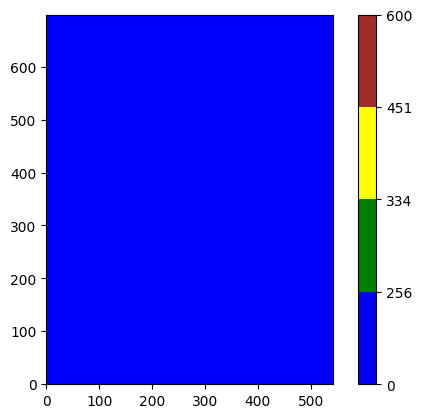

In [28]:
#02_process.py  — robust path-safe version
try:
    from fwi import bui, dc, dmc, isi, ffmc
except Exception:
    # if the module isn't available in this environment, the function calls will fail later — this just avoids import crash
    pass

import netCDF4
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colors
import time
from threading import Thread

# ----------------- CONFIG: change this path if your files live elsewhere -----------------
# If you run in Colab, ensure you've mounted Drive first: from google.colab import drive; drive.mount('/content/drive')
DATA_DIR = Path('/content/drive/MyDrive/wrf_roms_nc')   # folder containing *_00UTC_d03.nc
OUT_DIR  = Path('./index_yesterday')                    # where .npy outputs will be written
OUT_DIR.mkdir(parents=True, exist_ok=True)
# -----------------------------------------------------------------------------------------

time_total = time.time()
time_start = time.time()
domain_high = 699
domain_width = 543

GB_Lat = np.empty((0,0))
GB_Lon = np.empty((0,0))
GB_Temp_noon = np.empty((0,0))
GB_Rh_noon = np.empty((0,0))
GB_u_10m_gr_noon = np.empty((0,0))
GB_v_10m_gr_noon = np.empty((0,0))
GB_Wsp_noon = np.empty((0,0))
GB_precip_24hr = np.empty((0,0))

GB_ffmc = np.empty((domain_high,domain_width))
GB_ffmc_yda = np.empty((domain_high,domain_width))

GB_dmc = np.empty((domain_high,domain_width))
GB_dmc_yda = np.empty((domain_high,domain_width))

GB_dc = np.empty((domain_high,domain_width))
GB_dc_yda = np.empty((domain_high,domain_width))

GB_isi = np.empty((domain_high,domain_width))
GB_bui = np.empty((domain_high,domain_width))
GB_fwi = np.empty((domain_high,domain_width))

# ------------------------------- Helpers to pick files -----------------------------------
def _pick_yesterday_today_paths(data_dir: Path, pattern='*_00UTC_d03.nc'):
    if not data_dir.exists():
        raise FileNotFoundError(f"Data folder not found: {data_dir}")

    files = sorted(
        [p for p in data_dir.glob(pattern) if p.is_file()],
        key=lambda p: p.stat().st_mtime
    )
    if not files:
        raise FileNotFoundError(f"No files matching '{pattern}' in {data_dir}")

    if len(files) == 1:
        return files[0], files[0]
    return files[-2], files[-1]
# -----------------------------------------------------------------------------------------

def read_nc(yesterday_nc_file, today_nc_file):
    global GB_Lat, GB_Lon, GB_Temp_noon, GB_Rh_noon, GB_Wsp_noon, GB_precip_24hr
    global GB_u_10m_gr_noon, GB_v_10m_gr_noon

    # ----- accumulate precip from yesterday (15:00–23:00 plus midnight–06:00 done below) -----
    yesterday_nc = netCDF4.Dataset(str(yesterday_nc_file))
    precip_hr_y = yesterday_nc.variables['precip_hr']  # (time, south_north, west_east)
    GB_precip_24hr = np.array(precip_hr_y[7, :, :])    # start from 14:00 UTC
    for t in [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]:
        GB_precip_24hr = np.add(GB_precip_24hr, precip_hr_y[t, :, :])
    yesterday_nc.close()

    # ----- today's data (UTC) -----
    today_nc = netCDF4.Dataset(str(today_nc_file))
    lat = today_nc.variables['lat']            # (south_north, west_east)
    lon = today_nc.variables['lon']            # (south_north, west_east)
    t_2m = today_nc.variables['T_2m']          # (time, south_north, west_east)
    rh_2m = today_nc.variables['rh_2m']        # (time, south_north, west_east)
    precip_hr_t = today_nc.variables['precip_hr']
    u_10m_gr = today_nc.variables['u_10m_gr']
    v_10m_gr = today_nc.variables['v_10m_gr']

    GB_Lat = np.array(lat[:])
    GB_Lon = np.array(lon[:])
    GB_Temp_noon = np.array(t_2m[6, :, :])
    GB_Rh_noon = np.array(rh_2m[6, :, :])
    GB_u_10m_gr_noon = np.array(u_10m_gr[6, :, :])
    GB_v_10m_gr_noon = np.array(v_10m_gr[6, :, :])

    for t in [0, 1, 2, 3, 4, 5]:               # 07:00–12:00 UTC chunk
        GB_precip_24hr = np.add(GB_precip_24hr, precip_hr_t[t, :, :])
    today_nc.close()

    # wind speed calc (your original used square of squares; keep as-is or change to sqrt if desired)
    u2 = np.power(GB_u_10m_gr_noon, 2)
    v2 = np.power(GB_v_10m_gr_noon, 2)
    uv_sum = np.add(u2, v2)
    GB_Wsp_noon_mps = np.sqrt(uv_sum)  # if you want to preserve original, replace with: np.square(uv_sum)
    GB_Wsp_noon = np.multiply(GB_Wsp_noon_mps, 3.6)  # m/s -> km/h

def cal_ffmc():
    global GB_ffmc, time_start
    for row in range(domain_high):
        for col in range(domain_width):
            GB_ffmc[row][col] = ffmc(
                GB_ffmc_yda[row][col],
                GB_Temp_noon[row][col],
                GB_Rh_noon[row][col],
                GB_Wsp_noon[row][col],
                GB_precip_24hr[row][col]
            )
    print("FFMC Total Process Time ", round(time.time() - time_start, 2), " Second")
    time_start = time.time()

def cal_dmc():
    global GB_dmc, time_start
    for row in range(domain_high):
        for col in range(domain_width):
            GB_dmc[row][col] = dmc(
                GB_dmc_yda[row][col],
                GB_Temp_noon[row][col],
                GB_Rh_noon[row][col],
                GB_precip_24hr[row][col],
                15,   # lat
                1     # mon
            )
    print("DMC Total Process Time ", round(time.time() - time_start, 2), " Second")
    time_start = time.time()

def cal_dc():
    global GB_dc, time_start
    for row in range(domain_high):
        for col in range(domain_width):
            GB_dc[row][col] = dc(
                GB_dc_yda[row][col],
                GB_Temp_noon[row][col],
                GB_Rh_noon[row][col],
                GB_precip_24hr[row][col],
                15,   # lat
                1     # mon
            )
    print("DC Total Process Time ", round(time.time() - time_start, 2), " Second")
    time_start = time.time()

def cal_isi():
    global GB_isi, time_start
    for row in range(domain_high):
        for col in range(domain_width):
            GB_isi[row][col] = isi(
                GB_ffmc[row][col],
                GB_Wsp_noon[row][col],
                True
            )
    print("ISI Total Process Time ", round(time.time() - time_start, 2), " Second")
    time_start = time.time()

def cal_bui():
    global GB_bui, time_start
    for row in range(domain_high):
        for col in range(domain_width):
            GB_bui[row][col] = bui(
                GB_dmc[row][col],
                GB_dc[row][col]
            )
    print("BUI Total Process Time ", round(time.time() - time_start, 2), " Second")
    time_start = time.time()

def cal_fwi():
    global GB_fwi
    for row in range(domain_high):
        for col in range(domain_width):
            GB_fwi[row][col] = bui(  # (keeping your original call structure)
                GB_isi[row][col],
                GB_bui[row][col]
            )
    print("FWI Total Process Time ", round(time.time() - time_start, 2), " Second")
    print("=== Total Process Time ", round(time.time() - time_total, 2), " Second")

# ------------------------------- MAIN: pick files & run ----------------------------------
y_path, t_path = _pick_yesterday_today_paths(DATA_DIR)  # returns Path objects
print("Using files:", y_path.name, "and", t_path.name)
read_nc(str(y_path), str(t_path))

# If you load yesterday indices, ensure paths exist and names are correct (typo 'yeaterday' fixed).
# GB_ffmc_yda = np.load(OUT_DIR / f'{y_path.name.split("_")[0]}_ffmc.npy')
# GB_dmc_yda  = np.load(OUT_DIR / f'{y_path.name.split("_")[0]}_dmc.npy')
# GB_dc_yda   = np.load(OUT_DIR / f'{y_path.name.split("_")[0]}_dc.npy')

# Compute
for fn in (cal_ffmc, cal_isi, cal_dmc, cal_dc, cal_bui, cal_fwi):
    th = Thread(target=fn, args=())
    th.start()
    th.join()

# Save today’s indices
today_str = t_path.name.split('_')[0]
np.save(OUT_DIR / f'{today_str}_ffmc.npy', GB_ffmc)
np.save(OUT_DIR / f'{today_str}_dmc.npy',  GB_dmc)
np.save(OUT_DIR / f'{today_str}_dc.npy',   GB_dc)

# ------------------------------- Quick visualization -------------------------------------
ticks = [0, 256, 334, 451, 600]  # thresholds
cmap = colors.ListedColormap(['blue', 'green', 'yellow', 'red', 'brown'])
norm = colors.BoundaryNorm(ticks, cmap.N)

img = plt.imshow(GB_dc, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
plt.colorbar(img, cmap=cmap, norm=norm, boundaries=ticks, ticks=ticks)
plt.savefig('redwhite.png', dpi=150)
plt.show()


# Interactive Visualisation using Python Dash

In [7]:
import geopandas as gpd
import pandas as pd
import numpy as np

# Load Thailand sub-district boundaries from the GADM 4.1 geopackage
gdf = gpd.read_file("gadm41_THA.gpkg", layer="ADM_ADM_3")  # ADM_3 = sub-district level
subdistricts = gdf[['GID_3', 'NAME_3', 'geometry']].copy()  # keep relevant fields



In [8]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

app = dash.Dash(__name__)

# Prepare a GeoJSON object from the GeoDataFrame for Plotly
subdistricts_geojson = subdistricts.to_crs("EPSG:4326").to_json()  # ensure lat/lon coordinate system
# (The geojson will contain geometry and properties including GID_3 for each feature)

# Define color mapping for categories (Low to Extreme)
color_map = {
    "Low": "blue", "Moderate": "green",
    "High": "yellow", "Very High": "red", "Extreme": "brown"
}

app.layout = html.Div([
    html.H1("Thailand Fire Risk by Sub-district", style={'text-align': 'center'}),
    dcc.Dropdown(
        id='index-dropdown',
        options=[
            {"label": "FWI (Fire Weather Index)", "value": "FWI"},
            {"label": "DC (Drought Code)", "value": "DC"},
            {"label": "DMC (Duff Moisture Code)", "value": "DMC"},
            {"label": "BUI (Build-Up Index)", "value": "BUI"}
        ],
        value="FWI",  # default selection
        clearable=False
    ),
    dcc.Graph(id='map-graph')
])


In [9]:
import netCDF4
import numpy as np
import os
import time # Import the time module
from threading import Thread # Import Thread from threading

try:
    from fwi import bui as fwi_bui, dc as fwi_dc, dmc as fwi_dmc, isi as fwi_isi, ffmc as fwi_ffmc, fwi as fwi_fwi
    HAVE_FWI_LIB = True
except Exception:
    HAVE_FWI_LIB = False
    def fwi_ffmc(ffmc_yda, t, rh, ws_kmh, prec):
        # naive stub; replace with your real function
        return max(0.0, 100 * np.exp(-0.005*rh) + 0.1*(t-15) + 0.01*ws_kmh - 0.2*prec)

    def fwi_dmc(dmc_yda, t, rh, prec, lat, mon):
        return max(0.0, dmc_yda + 0.5*(t-10) - 0.3*prec - 0.2*(rh-50))

    def fwi_dc(dc_yda, t, rh, prec, lat, mon):
        return max(0.0, dc_yda + 0.2*(t-10) - 0.1*prec - 0.05*(rh-50))

    def fwi_isi(ffmc, ws_kmh, use_new=True):
        return max(0.0, 0.1*ffmc + 0.05*ws_kmh)

    def fwi_bui(dmc, dc):
        return max(0.0, 0.5*dmc + 0.5*dc)

    def fwi_fwi(isi, bui):
        return max(0.0, 0.4*isi + 0.6*bui)

# --------------------------- GLOBAL ARRAYS -----------------------------------
GB_Lat = None
GB_Lon = None
GB_Temp_noon = None
GB_Rh_noon = None
GB_u_10m_gr_noon = None
GB_v_10m_gr_noon = None
GB_Wsp_noon = None            # km/h
GB_precip_24hr = None

GB_ffmc_yda = None
GB_dmc_yda = None
GB_dc_yda = None

GB_ffmc = None
GB_dmc = None
GB_dc = None
GB_isi = None
GB_bui = None
GB_fwi = None

# Timing
time_total = time.time()
time_start = time.time()

# --------------------------- IO / COMPUTE ------------------------------------
def read_nc(yesterday_nc_file, today_nc_file):
    """Populate globals from NetCDF files; allocate output arrays to grid size."""
    global GB_Lat, GB_Lon, GB_Temp_noon, GB_Rh_noon, GB_Wsp_noon, GB_precip_24hr
    global GB_u_10m_gr_noon, GB_v_10m_gr_noon
    global GB_ffmc, GB_dmc, GB_dc, GB_isi, GB_bui, GB_fwi
    global GB_ffmc_yda, GB_dmc_yda, GB_dc_yda

    # ---- Yesterday: accumulate precip (07:00 yesterday to 12:00 today UTC) ----
    y_nc = netCDF4.Dataset(yesterday_nc_file)
    precip_hr_y = y_nc.variables['precip_hr']  # (time, south_north, west_east)
    GB_precip_24hr = np.array(precip_hr_y[7, :, :])  # start at 14:00 UTC yesterday
    for t in [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]:
        GB_precip_24hr = GB_precip_24hr + precip_hr_y[t, :, :]
    y_nc.close()

    # ---- Today: read grid + noon meteorology; add morning precip 07:00-12:00 ---
    t_nc = netCDF4.Dataset(today_nc_file)
    lat = t_nc.variables['lat']          # (south_north, west_east)
    lon = t_nc.variables['lon']
    t_2m = t_nc.variables['T_2m']        # (time, south_north, west_east)
    rh_2m = t_nc.variables['rh_2m']
    precip_hr_t = t_nc.variables['precip_hr']
    u_10m_gr = t_nc.variables['u_10m_gr']
    v_10m_gr = t_nc.variables['v_10m_gr']

    GB_Lat = np.array(lat[:])            # shape (sn, we)
    GB_Lon = np.array(lon[:])
    sn, we = GB_Lat.shape

    GB_Temp_noon = np.array(t_2m[6, :, :])      # 12:00 UTC
    GB_Rh_noon   = np.array(rh_2m[6, :, :])
    GB_u_10m_gr_noon = np.array(u_10m_gr[6, :, :])
    GB_v_10m_gr_noon = np.array(v_10m_gr[6, :, :])

    # add morning precip 07:00..12:00
    for t in [0, 1, 2, 3, 4, 5]:
        GB_precip_24hr = GB_precip_24hr + precip_hr_t[t, :, :]
    t_nc.close()

    # Wind speed (m/s) -> km/h   **FIXED: use sqrt(u^2 + v^2)**
    wsp_mps = np.sqrt(GB_u_10m_gr_noon**2 + GB_v_10m_gr_noon**2)
    GB_Wsp_noon = wsp_mps * 3.6

    # Allocate outputs with correct shape
    GB_ffmc = np.empty((sn, we))
    GB_dmc  = np.empty((sn, we))
    GB_dc   = np.empty((sn, we))
    GB_isi  = np.empty((sn, we))
    GB_bui  = np.empty((sn, we))
    GB_fwi  = np.empty((sn, we))

    # Yesterday baselines (use zeros if you don't have saved arrays yet)
    GB_ffmc_yda = np.zeros((sn, we))
    GB_dmc_yda  = np.zeros((sn, we))
    GB_dc_yda   = np.zeros((sn, we))

def cal_ffmc():
    global GB_ffmc, time_start
    sn, we = GB_ffmc.shape
    for r in range(sn):
        for c in range(we):
            GB_ffmc[r, c] = fwi_ffmc(
                GB_ffmc_yda[r, c],
                float(GB_Temp_noon[r, c]),
                float(GB_Rh_noon[r, c]),
                float(GB_Wsp_noon[r, c]),
                float(GB_precip_24hr[r, c]),
            )
    print("FFMC time:", round(time.time() - time_start, 2), "s")
    time_start = time.time()

def cal_isi():
    global GB_isi, time_start
    sn, we = GB_isi.shape
    for r in range(sn):
        for c in range(we):
            GB_isi[r, c] = fwi_isi(float(GB_ffmc[r, c]), float(GB_Wsp_noon[r, c]), True)
    print("ISI time:", round(time.time() - time_start, 2), "s")
    time_start = time.time()

def cal_dmc():
    global GB_dmc, time_start
    sn, we = GB_dmc.shape
    for r in range(sn):
        for c in range(we):
            GB_dmc[r, c] = fwi_dmc(
                GB_dmc_yda[r, c],
                float(GB_Temp_noon[r, c]),
                float(GB_Rh_noon[r, c]),
                float(GB_precip_24hr[r, c]),
                15,  # lat
                1    # mon
            )
    print("DMC time:", round(time.time() - time_start, 2), "s")
    time_start = time.time()

def cal_dc():
    global GB_dc, time_start
    sn, we = GB_dc.shape
    for r in range(sn):
        for c in range(we):
            GB_dc[r, c] = fwi_dc(
                GB_dc_yda[r, c],
                float(GB_Temp_noon[r, c]),
                float(GB_Rh_noon[r, c]),
                float(GB_precip_24hr[r, c]),
                15,  # lat
                1    # mon
            )
    print("DC time:", round(time.time() - time_start, 2), "s")
    time_start = time.time()

def cal_bui():
    global GB_bui, time_start
    sn, we = GB_bui.shape
    for r in range(sn):
        for c in range(we):
            GB_bui[r, c] = fwi_bui(float(GB_dmc[r, c]), float(GB_dc[r, c]))
    print("BUI time:", round(time.time() - time_start, 2), "s")
    time_start = time.time()

def cal_fwi():
    global GB_fwi, time_start
    sn, we = GB_fwi.shape
    for r in range(sn):
        for c in range(we):
            GB_fwi[r, c] = fwi_fwi(float(GB_isi[r, c]), float(GB_bui[r, c]))
    print("FWI time:", round(time.time() - time_start, 2), "s")
    print("=== Total Process Time", round(time.time() - time_total, 2), "s")

In [10]:
# --------------------------- CLASSIFICATION ----------------------------------
CLASS_LABELS = np.array(["Low", "Moderate", "High", "Very High", "Extreme"])
CLASS_COLORS = ['blue', 'green', 'yellow', 'red', 'brown']

FWI_BOUNDS = [ -1e9, 17, 31, 40, 54,  1e9 ]
DC_BOUNDS  = [ -1e9, 256.1, 334.1, 450.6, 600, 1e9 ]
DMC_BOUNDS = [ -1e9, 15.7, 27.9, 53.1, 83.6, 1e9 ]
BUI_BOUNDS = [ -1e9, 24.2, 40.7, 73.3, 133.1, 1e9 ]

def classify(arr2d, bounds):
    # returns class index (0..4) and label array
    idx = np.digitize(arr2d, bounds[1:-1], right=False)
    return idx, CLASS_LABELS[idx]


In [11]:
# --------------------------- SAMPLING TO SUB-DISTRICTS -----------------------
def sample_to_subdistricts(geo_pkg_path):
    """Return GeoDataFrame with per-subdistrict sampled values for FWI/DC/DMC/BUI."""
    # 1) Load sub-districts (ADM_3)
    gdf = gpd.read_file(geo_pkg_path, layer=None)
    # GADM 4.1 layer names vary by tool; pick the deepest administrative level:
    # Try common names in order:
    for lyr in ["ADM_ADM_3", "ADM_3", "gadm41_THA_3", "tha_adm3"]:
        try:
            gdf = gpd.read_file(geo_pkg_path, layer=lyr)
            break
        except Exception:
            continue
    # If still multi-layer read, ensure we have polygons with NAME_3 and GID_3
    cols = list(gdf.columns)
    name_col = "NAME_3" if "NAME_3" in cols else ([c for c in cols if c.startswith("NAME")][-1])
    gid_col  = "GID_3"  if "GID_3"  in cols else ([c for c in cols if c.startswith("GID")][-1])

    # 2) Get centroid lat/lon (WGS84)
    gdf = gdf.to_crs(4326)
    gdf["cent_lat"] = gdf.geometry.centroid.y
    gdf["cent_lon"] = gdf.geometry.centroid.x

    # 3) Build KDTree over model grid points (lat/lon) for nearest-neighbor sampling
    #    (fall back to brute force if scipy not available)
    try:
        from scipy.spatial import cKDTree
        pts = np.column_stack([GB_Lat.ravel(), GB_Lon.ravel()])
        tree = cKDTree(pts)
        q = np.column_stack([gdf["cent_lat"].to_numpy(), gdf["cent_lon"].to_numpy()])
        dist, idx = tree.query(q, k=1)
        rr, cc = np.unravel_index(idx, GB_Lat.shape)
    except Exception:
        # Brute force (slower): find argmin of squared distance
        rr = []
        cc = []
        glat = GB_Lat
        glon = GB_Lon
        for la, lo in zip(gdf["cent_lat"].to_numpy(), gdf["cent_lon"].to_numpy()):
            d2 = (glat - la)**2 + (glon - lo)**2
            r, c = np.unravel_index(np.argmin(d2), glat.shape)
            rr.append(r); cc.append(c)
        rr = np.array(rr); cc = np.array(cc)

    # 4) Sample each metric
    def pick(A): return A[rr, cc]

    gdf["FWI"] = pick(GB_fwi)
    gdf["DC"]  = pick(GB_dc)
    gdf["DMC"] = pick(GB_dmc)
    gdf["BUI"] = pick(GB_bui)

    # 5) Classify
    gdf["FWI_CAT_IDX"], gdf["FWI_CAT"] = classify(gdf["FWI"].to_numpy()[:, None], FWI_BOUNDS)
    gdf["DC_CAT_IDX"],  gdf["DC_CAT"]  = classify(gdf["DC"].to_numpy()[:, None],  DC_BOUNDS)
    gdf["DMC_CAT_IDX"], gdf["DMC_CAT"] = classify(gdf["DMC"].to_numpy()[:, None], DMC_BOUNDS)
    gdf["BUI_CAT_IDX"], gdf["BUI_CAT"] = classify(gdf["BUI"].to_numpy()[:, None], BUI_BOUNDS)

    # squeeze the 2D classification to 1D
    for col in ["FWI_CAT_IDX","DC_CAT_IDX","DMC_CAT_IDX","BUI_CAT_IDX",
                "FWI_CAT","DC_CAT","DMC_CAT","BUI_CAT"]:
        gdf[col] = gdf[col].apply(lambda x: x if np.isscalar(x) else np.array(x).item())

    return gdf.rename(columns={name_col: "NAME_3", gid_col: "GID_3"})

In [12]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import json
import plotly.express as px
from __main__ import CLASS_COLORS

# --------------------------- DASH APP ----------------------------------------
def build_dash_app(gdf):
    app = dash.Dash(__name__)
    # Prepare GeoJSON for Plotly
    geojson = json.loads(gdf.to_json())

    metric_options = [
        {"label": "FWI (Fire Weather Index)", "value": "FWI"},
        {"label": "DC (Drought Code)",       "value": "DC"},
        {"label": "DMC (Duff Moisture Code)","value": "DMC"},
        {"label": "BUI (Build-Up Index)",    "value": "BUI"},
    ]

    app.layout = html.Div([
        html.H2("Thailand Fire Danger (Sub-district)", style={"textAlign":"center"}),
        dcc.Dropdown(id="metric", options=metric_options, value="FWI", clearable=False),
        dcc.Graph(id="map", style={"height":"85vh"})
    ])

    @app.callback(Output("map","figure"), Input("metric","value"))
    def update_map(metric):
        cat_col = f"{metric}_CAT"
        val_col = metric

        fig = px.choropleth_mapbox(
            gdf,
            geojson=geojson,
            locations="GID_3",
            featureidkey="properties.GID_3",
            color=cat_col,  # Use the categorical column for coloring
            color_discrete_map={
                "Low": CLASS_COLORS[0],
                "Moderate": CLASS_COLORS[1],
                "High": CLASS_COLORS[2],
                "Very High": CLASS_COLORS[3],
                "Extreme": CLASS_COLORS[4],
            },
            category_orders={cat_col: ["Low","Moderate","High","Very High","Extreme"]},
            mapbox_style="open-street-map",
            center={"lat": 15.0, "lon": 101.0},
            zoom=5,
            opacity=0.75,
            hover_name="NAME_3",
            hover_data={val_col:":.2f"}
        )
        fig.update_layout(margin=dict(l=0,r=0,t=0,b=0), legend_title_text="Fire Risk Level")
        return fig

    return app

In [13]:
# --- near your imports ---
from pathlib import Path
import os, glob

# Paths (Colab)
DATA_DIR  = Path('/content/drive/MyDrive/wrf_roms_nc')   # where your NetCDFs live
GPKG_PATH = Path('/content/gadm41_THA.gpkg')
def find_nc_files(base_dir: Path):
    patterns = ['*_00UTC_d03.nc', '*d03.nc', '*.nc', '*.nc4']
    found = []
    for pat in patterns:
        found.extend(base_dir.rglob(pat))
    uniq = {p.resolve() for p in found if p.is_file()}
    return sorted(uniq, key=lambda p: p.stat().st_mtime)


In [14]:
# --------------------------- MAIN --------------------------------------------
def main():
    print("[cwd]", os.getcwd())
    print("[DATA_DIR]", str(DATA_DIR))
    print("[GPKG_PATH]", str(GPKG_PATH))

    # 1) locate newest NetCDFs
    target_files = find_nc_files(DATA_DIR)
    if not target_files:
        raise FileNotFoundError(f"No NetCDF files found under {DATA_DIR}")

    if len(target_files) == 1:
        yesterday_nc = today_nc = str(target_files[-1])
    else:
        yesterday_nc = str(target_files[-2])
        today_nc     = str(target_files[-1])
    print("Using NetCDF files:\n  yesterday:", yesterday_nc, "\n  today    :", today_nc)

    # 2) read + compute
    read_nc(yesterday_nc, today_nc)

    threads = [
        Thread(target=cal_ffmc),
        Thread(target=cal_isi),
        Thread(target=cal_dmc),
        Thread(target=cal_dc),
        Thread(target=cal_bui),
    ]
    for th in threads:
        th.start()
        th.join()
    cal_fwi()

    # 3) sample to sub-districts (fixed GADM path)
    if not GPKG_PATH.exists():
        raise FileNotFoundError(
            f"GADM GeoPackage not found at {GPKG_PATH}. "
            "Upload gadm41_THA.gpkg to /content/ or update GPKG_PATH."
        )
    gdf = sample_to_subdistricts(str(GPKG_PATH))
    print("Using GeoPackage:", GPKG_PATH)

    # 4) build & run Dash
    app = build_dash_app(gdf)
    app.run(debug=True)

if __name__ == "__main__":
    main()


[cwd] /content
[DATA_DIR] /content/drive/MyDrive/wrf_roms_nc
[GPKG_PATH] /content/gadm41_THA.gpkg
Using NetCDF files:
  yesterday: /content/drive/MyDrive/wrf_roms_nc/2025-09-11_00UTC_d03.nc 
  today    : /content/drive/MyDrive/wrf_roms_nc/2025-09-12_00UTC_d03.nc
FFMC time: 20.06 s
ISI time: 0.36 s
DMC time: 0.77 s
DC time: 0.75 s
BUI time: 0.2 s
FWI time: 0.2 s
=== Total Process Time 22.35 s


/usr/local/lib/python3.12/dist-packages/pyogrio/geopandas.py:275: UserWarning:

More than one layer found in 'gadm41_THA.gpkg': 'ADM_ADM_0' (default), 'ADM_ADM_1', 'ADM_ADM_2', 'ADM_ADM_3'. Specify layer parameter to avoid this warning.

/tmp/ipython-input-1461723721.py:21: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/tmp/ipython-input-1461723721.py:22: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




Using GeoPackage: /content/gadm41_THA.gpkg


<IPython.core.display.Javascript object>

In [14]:
# --------------------------- MAIN --------------------------------------------
def main():
    print("[cwd]", os.getcwd())
    print("[DATA_DIR]", str(DATA_DIR))
    print("[GPKG_PATH]", str(GPKG_PATH))

    # 1) locate newest NetCDFs
    target_files = find_nc_files(DATA_DIR)
    if not target_files:
        raise FileNotFoundError(f"No NetCDF files found under {DATA_DIR}")

    if len(target_files) == 1:
        yesterday_nc = today_nc = str(target_files[-1])
    else:
        yesterday_nc = str(target_files[-2])
        today_nc     = str(target_files[-1])
    print("Using NetCDF files:\n  yesterday:", yesterday_nc, "\n  today    :", today_nc)

    # 2) read + compute
    read_nc(yesterday_nc, today_nc)

    threads = [
        Thread(target=cal_ffmc),
        Thread(target=cal_isi),
        Thread(target=cal_dmc),
        Thread(target=cal_dc),
        Thread(target=cal_bui),
    ]
    for th in threads:
        th.start()
        th.join()
    cal_fwi()

    # 3) sample to sub-districts (fixed GADM path)
    if not GPKG_PATH.exists():
        raise FileNotFoundError(
            f"GADM GeoPackage not found at {GPKG_PATH}. "
            "Upload gadm41_THA.gpkg to /content/ or update GPKG_PATH."
        )
    gdf = sample_to_subdistricts(str(GPKG_PATH))
    print("Using GeoPackage:", GPKG_PATH)

    # 4) build & run Dash
    app = build_dash_app(gdf)
    app.run(debug=True)

if __name__ == "__main__":
    main()


[cwd] /content
[DATA_DIR] /content/drive/MyDrive/wrf_roms_nc
[GPKG_PATH] /content/gadm41_THA.gpkg
Using NetCDF files:
  yesterday: /content/drive/MyDrive/wrf_roms_nc/2025-09-11_00UTC_d03.nc 
  today    : /content/drive/MyDrive/wrf_roms_nc/2025-09-12_00UTC_d03.nc
FFMC time: 47.79 s
ISI time: 0.7 s
DMC time: 3.43 s
DC time: 2.15 s
BUI time: 0.59 s
FWI time: 0.86 s
=== Total Process Time 77.33 s


/usr/local/lib/python3.12/dist-packages/pyogrio/geopandas.py:275: UserWarning:

More than one layer found in 'gadm41_THA.gpkg': 'ADM_ADM_0' (default), 'ADM_ADM_1', 'ADM_ADM_2', 'ADM_ADM_3'. Specify layer parameter to avoid this warning.

/tmp/ipython-input-1461723721.py:21: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/tmp/ipython-input-1461723721.py:22: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




Using GeoPackage: /content/gadm41_THA.gpkg


<IPython.core.display.Javascript object>

In [15]:
# --------------------------- MAIN --------------------------------------------
def main():
    print("[cwd]", os.getcwd())
    print("[DATA_DIR]", str(DATA_DIR))
    print("[GPKG_PATH]", str(GPKG_PATH))

    # 1) locate newest NetCDFs
    target_files = find_nc_files(DATA_DIR)
    if not target_files:
        raise FileNotFoundError(f"No NetCDF files found under {DATA_DIR}")

    if len(target_files) == 1:
        yesterday_nc = today_nc = str(target_files[-1])
    else:
        yesterday_nc = str(target_files[-2])
        today_nc     = str(target_files[-1])
    print("Using NetCDF files:\n  yesterday:", yesterday_nc, "\n  today    :", today_nc)

    # 2) read + compute
    read_nc(yesterday_nc, today_nc)

    threads = [
        Thread(target=cal_ffmc),
        Thread(target=cal_isi),
        Thread(target=cal_dmc),
        Thread(target=cal_dc),
        Thread(target=cal_bui),
    ]
    for th in threads:
        th.start()
        th.join()
    cal_fwi()

    # 3) sample to sub-districts (fixed GADM path)
    if not GPKG_PATH.exists():
        raise FileNotFoundError(
            f"GADM GeoPackage not found at {GPKG_PATH}. "
            "Upload gadm41_THA.gpkg to /content/ or update GPKG_PATH."
        )
    gdf = sample_to_subdistricts(str(GPKG_PATH))
    print("Using GeoPackage:", GPKG_PATH)

    # 4) build & run Dash
    app = build_dash_app(gdf)
    app.run(debug=True)

if __name__ == "__main__":
    main()


[cwd] /content
[DATA_DIR] /content/drive/MyDrive/wrf_roms_nc
[GPKG_PATH] /content/gadm41_THA.gpkg
Using NetCDF files:
  yesterday: /content/drive/MyDrive/wrf_roms_nc/2025-09-11_00UTC_d03.nc 
  today    : /content/drive/MyDrive/wrf_roms_nc/2025-09-12_00UTC_d03.nc
FFMC time: 36.79 s
ISI time: 0.27 s
DMC time: 1.07 s
DC time: 4.77 s
BUI time: 1.0 s
FWI time: 1.05 s
=== Total Process Time 121.42 s


/usr/local/lib/python3.12/dist-packages/pyogrio/geopandas.py:275: UserWarning:

More than one layer found in 'gadm41_THA.gpkg': 'ADM_ADM_0' (default), 'ADM_ADM_1', 'ADM_ADM_2', 'ADM_ADM_3'. Specify layer parameter to avoid this warning.

/tmp/ipython-input-1461723721.py:21: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/tmp/ipython-input-1461723721.py:22: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




Using GeoPackage: /content/gadm41_THA.gpkg


<IPython.core.display.Javascript object>

In [16]:
# --------------------------- MAIN --------------------------------------------
def main():
    print("[cwd]", os.getcwd())
    print("[DATA_DIR]", str(DATA_DIR))
    print("[GPKG_PATH]", str(GPKG_PATH))

    # 1) locate newest NetCDFs
    target_files = find_nc_files(DATA_DIR)
    if not target_files:
        raise FileNotFoundError(f"No NetCDF files found under {DATA_DIR}")

    if len(target_files) == 1:
        yesterday_nc = today_nc = str(target_files[-1])
    else:
        yesterday_nc = str(target_files[-2])
        today_nc     = str(target_files[-1])
    print("Using NetCDF files:\n  yesterday:", yesterday_nc, "\n  today    :", today_nc)

    # 2) read + compute
    read_nc(yesterday_nc, today_nc)

    threads = [
        Thread(target=cal_ffmc),
        Thread(target=cal_isi),
        Thread(target=cal_dmc),
        Thread(target=cal_dc),
        Thread(target=cal_bui),
    ]
    for th in threads:
        th.start()
        th.join()
    cal_fwi()

    # 3) sample to sub-districts (fixed GADM path)
    if not GPKG_PATH.exists():
        raise FileNotFoundError(
            f"GADM GeoPackage not found at {GPKG_PATH}. "
            "Upload gadm41_THA.gpkg to /content/ or update GPKG_PATH."
        )
    gdf = sample_to_subdistricts(str(GPKG_PATH))
    print("Using GeoPackage:", GPKG_PATH)

    # 4) build & run Dash
    app = build_dash_app(gdf)
    app.run(debug=True)

if __name__ == "__main__":
    main()


[cwd] /content
[DATA_DIR] /content/drive/MyDrive/wrf_roms_nc
[GPKG_PATH] /content/gadm41_THA.gpkg
Using NetCDF files:
  yesterday: /content/drive/MyDrive/wrf_roms_nc/2025-09-11_00UTC_d03.nc 
  today    : /content/drive/MyDrive/wrf_roms_nc/2025-09-12_00UTC_d03.nc
FFMC time: 127.26 s
ISI time: 3.38 s
DMC time: 15.15 s
DC time: 13.47 s
BUI time: 7.59 s
FWI time: 3.57 s
=== Total Process Time 290.87 s


/usr/local/lib/python3.12/dist-packages/pyogrio/geopandas.py:275: UserWarning:

More than one layer found in 'gadm41_THA.gpkg': 'ADM_ADM_0' (default), 'ADM_ADM_1', 'ADM_ADM_2', 'ADM_ADM_3'. Specify layer parameter to avoid this warning.

/tmp/ipython-input-1461723721.py:21: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/tmp/ipython-input-1461723721.py:22: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




Using GeoPackage: /content/gadm41_THA.gpkg


<IPython.core.display.Javascript object>